# EJERCICIO CLASE FINAL GRUPO 4

## INTEGRANTES:
- Carlos Chicaiza
- Emilio Mayorga
- Jessica Llumiguano
- Juan Vizuete

Se obtuvo los datos de un libro de Kaggle: https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset/data


## Levantamiento de proyecto

In [ ]:
%pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# base de datos
import psycopg2

### Lectura de los datos

In [2]:
with open('./data/cybersecurity_intrusion_data.csv', 'r') as data:
    cabecera = data.readline()
    print(cabecera)

session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected



In [3]:
df = pd.read_csv('./data/cybersecurity_intrusion_data.csv')
print(df.shape)

(9537, 11)


In [4]:
print(df.dtypes)

session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object


### Conexión con el servicio Postgres 

In [5]:
try:
    connection = psycopg2.connect(
        user="postgres", 
        password="postgres",
        host="localhost",
        port="5432"
    )
    connection.autocommit = True
    cursor = connection.cursor()
    cursor.execute("SELECT datname FROM pg_database WHERE datname='cybersecurity_intrusion';")
    if not cursor.fetchone():
        cursor.execute("CREATE DATABASE cybersecurity_intrusion;")
        print("Base creada")
    else:
        print("Si existe")
    
    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al crear la base de datos: {e}")
    

Si existe


### Conexion con la base

In [6]:
try:
    connection = psycopg2.connect(
        database = "cybersecurity_intrusion",
        user="postgres", 
        password="postgres",
        host="localhost",
        port="5432"
    )
    cursor = connection.cursor()
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='public' and table_name='intrusion_log'  ;")
    if not cursor.fetchone():
        cursor.execute("""
            CREATE TABLE intrusion_log(
                       id SERIAL PRIMARY KEY,
                       session_id varchar(10),
                       network_packet_size int,
                       protocol_type varchar(5),
                       login_attempts int,
                       session_duration double precision,
                       encryption_used varchar(5),
                       ip_reputation_score double precision,
                       failed_logins int,
                       browser_type varchar(10),
                       unusual_time_access int,
                       attack_detected int
                       );
         """)
        print("Tabla creada")
    else:
        print("Si existe")
    
    connection.commit()

    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al crear la tabla: {e}")
    

Si existe


## Preprocesamiento

In [7]:
print(df.isnull().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


Se convierte los campos de texto en minuscula

In [8]:
df_normalized = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
print(df_normalized[:5])

  session_id  network_packet_size protocol_type  login_attempts  \
0  sid_00001                  599           tcp               4   
1  sid_00002                  472           tcp               3   
2  sid_00003                  629           tcp               3   
3  sid_00004                  804           udp               4   
4  sid_00005                  453           tcp               5   

   session_duration encryption_used  ip_reputation_score  failed_logins  \
0        492.983263             des             0.606818              1   
1       1557.996461             des             0.301569              0   
2         75.044262             des             0.739164              2   
3        601.248835             des             0.123267              0   
4        532.540888             aes             0.054874              1   

  browser_type  unusual_time_access  attack_detected  
0         edge                    0                1  
1      firefox                    0 

Cambiar las celdas "Unknown" y "None" por "NaN"

In [9]:
df_normalized.replace(['unknown', None], np.nan, inplace=True)
print(df_normalized[10:20])

   session_id  network_packet_size protocol_type  login_attempts  \
10  sid_00011                  407           udp               6   
11  sid_00012                  406           udp               9   
12  sid_00013                  548           tcp               2   
13  sid_00014                  117           tcp               4   
14  sid_00015                  155           tcp               3   
15  sid_00016                  387          icmp               6   
16  sid_00017                  297           tcp               8   
17  sid_00018                  562           udp               1   
18  sid_00019                  318           tcp               5   
19  sid_00020                  217          icmp               2   

    session_duration encryption_used  ip_reputation_score  failed_logins  \
10        580.721925             des             0.122894              3   
11        191.052837             des             0.339711              1   
12        186.147638   

Se van a eliminar las filas con valores nulos

In [10]:
df_normalized.dropna(inplace=True)

In [11]:
print(df_normalized[0:10])

   session_id  network_packet_size protocol_type  login_attempts  \
0   sid_00001                  599           tcp               4   
1   sid_00002                  472           tcp               3   
2   sid_00003                  629           tcp               3   
4   sid_00005                  453           tcp               5   
5   sid_00006                  453           udp               5   
6   sid_00007                  815          icmp               4   
7   sid_00008                  653           tcp               3   
10  sid_00011                  407           udp               6   
11  sid_00012                  406           udp               9   
15  sid_00016                  387          icmp               6   

    session_duration encryption_used  ip_reputation_score  failed_logins  \
0         492.983263             des             0.606818              1   
1        1557.996461             des             0.301569              0   
2          75.044262   

Se ha limpiado la tabla.

### Iniciar guardado de datos

In [12]:
try:
    connection = psycopg2.connect(
        database = "cybersecurity_intrusion",
        user="postgres", 
        password="postgres",
        host="localhost",
        port="5432"
    )
    cursor = connection.cursor()
    
    logs = df_normalized[0:10]
    data_to_insert = [
    tuple(int(x) if isinstance(x, np.int64) else float(x) if isinstance(x, np.float64) else x for x in row)
    for row in logs[['session_id','network_packet_size','protocol_type','login_attempts','session_duration','encryption_used','ip_reputation_score','failed_logins','browser_type','unusual_time_access','attack_detected']].to_records(index=False)]   
    print(data_to_insert)
    cursor.executemany("""
        INSERT INTO intrusion_log (session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
        """,data_to_insert)

    connection.commit()
    print("Se han agregado los logs")
    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al insertar los datos: {e}")
    

[('sid_00001', 599, 'tcp', 4, 492.9832634426563, 'des', 0.606818080396889, 1, 'edge', 0, 1), ('sid_00002', 472, 'tcp', 3, 1557.9964611204384, 'des', 0.3015689675960893, 0, 'firefox', 0, 0), ('sid_00003', 629, 'tcp', 3, 75.04426166420741, 'des', 0.7391643279163831, 2, 'chrome', 0, 1), ('sid_00005', 453, 'tcp', 5, 532.5408884201419, 'aes', 0.0548738567431703, 1, 'firefox', 0, 0), ('sid_00006', 453, 'udp', 5, 380.4715502453134, 'aes', 0.4224858607066699, 2, 'chrome', 1, 0), ('sid_00007', 815, 'icmp', 4, 728.1071646972356, 'aes', 0.4137719285892984, 1, 'chrome', 0, 1), ('sid_00008', 653, 'tcp', 3, 12.5999060098958, 'des', 0.0977193658576949, 3, 'chrome', 1, 1), ('sid_00011', 407, 'udp', 6, 580.7219253670751, 'des', 0.1228937389064628, 3, 'firefox', 0, 1), ('sid_00012', 406, 'udp', 9, 191.0528369326706, 'des', 0.3397112713433893, 1, 'edge', 0, 1), ('sid_00016', 387, 'icmp', 6, 292.1361960073892, 'des', 0.2549124511362793, 3, 'chrome', 0, 1)]
Se han agregado los logs


Se han añadido los logs.
Se procede a imprimir la tabla

In [13]:
try:
    connection = psycopg2.connect(
        database = "cybersecurity_intrusion",
        user="postgres", 
        password="postgres",
        host="localhost",
        port="5432"
    )
    cursor = connection.cursor()
    
    cursor.execute("SELECT * FROM intrusion_log LIMIT 10;")
    result = cursor.fetchall()
    
    for i in result:
        print(i)

    print("Se ha realizado la impresion")
    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al insertar los datos: {e}")
    

(11, 'sid_00001', 599, 'tcp', 4, 492.9832634426563, 'des', 0.606818080396889, 1, 'edge', 0, 1)
(12, 'sid_00002', 472, 'tcp', 3, 1557.9964611204384, 'des', 0.3015689675960893, 0, 'firefox', 0, 0)
(13, 'sid_00003', 629, 'tcp', 3, 75.04426166420741, 'des', 0.7391643279163831, 2, 'chrome', 0, 1)
(14, 'sid_00005', 453, 'tcp', 5, 532.5408884201419, 'aes', 0.0548738567431703, 1, 'firefox', 0, 0)
(15, 'sid_00006', 453, 'udp', 5, 380.4715502453134, 'aes', 0.4224858607066699, 2, 'chrome', 1, 0)
(16, 'sid_00007', 815, 'icmp', 4, 728.1071646972356, 'aes', 0.4137719285892984, 1, 'chrome', 0, 1)
(17, 'sid_00008', 653, 'tcp', 3, 12.5999060098958, 'des', 0.0977193658576949, 3, 'chrome', 1, 1)
(18, 'sid_00011', 407, 'udp', 6, 580.7219253670751, 'des', 0.1228937389064628, 3, 'firefox', 0, 1)
(19, 'sid_00012', 406, 'udp', 9, 191.0528369326706, 'des', 0.3397112713433893, 1, 'edge', 0, 1)
(20, 'sid_00016', 387, 'icmp', 6, 292.1361960073892, 'des', 0.2549124511362793, 3, 'chrome', 0, 1)
Se ha realizado la i

## Gráficos

### Ataques recibidos por navegador

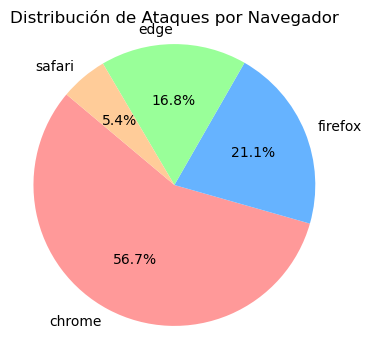

In [ ]:
# Filtrar solo los ataques detectados (attack_detected == 1)
df_attacks = df_normalized[df_normalized['attack_detected'] == 1]

# Contar los ataques por tipo de navegador
attack_counts = df_attacks['browser_type'].value_counts()

# Crear el gráfico de pastel
plt.figure(figsize=(4, 4))
plt.pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Distribución de Ataques por Navegador')
plt.axis('equal')  # Para hacer el gráfico circular

# Mostrar el gráfico
plt.show()